In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `CutOutRandom` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerRandom
from semantic_segmentation_augmentations.holesfilling import CutOutRandom

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch; torch.cuda.set_device(1)

Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        if len(x) == 2:
            img, mask = x
        elif len(x) == 1:
            img = x[0]
            mask = np.zeros_like(img)

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask
    
def decodes(mask):
    shape = mask.shape
    _mask = np.empty([*shape, 3])
    grape_c = np.array([255, 255, 255])
    leaves_c = np.array([0, 255, 0])
    pole_c = np.array([255, 0, 0])
    wood_c = np.array([0, 0, 255])
    back_c = np.array([0, 0, 0])
    
    for j in range(shape[0]):
        for i in range(shape[1]):
            if mask[j, i] == 1:
                _mask[j, i] = grape_c
            elif mask[j, i] == 2:
                _mask[j, i] = leaves_c
            elif mask[j, i] == 3:
                _mask[j, i] = pole_c
            elif mask[j, i] == 4:
                _mask[j, i] = wood_c
            else:
                _mask[j, i] = back_c
    
    return _mask.astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

saving_hparams = {
    "save_best": True,
    "metric": "DiceMulti",
    "model_name": "CutOutRandom"
}

In order to know how does this technique work, we can show an example:

This technique cuts a square from the image, randomly selected, and remove all the information inside that region.

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


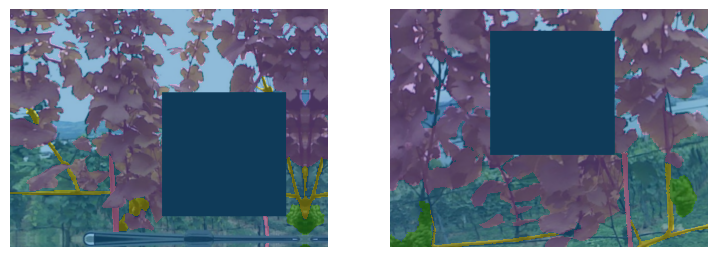

In [ ]:
cor = CutOutRandom(holes_num = 1, hole_maker = HoleMakerRandom((250, 250)), p = 1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cor) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cor.x, cor.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for holes_num in [1, 2, 3]:
    for size in [(100, 100), (200, 200), (300, 300)]:
        cor = CutOutRandom(holes_num = holes_num, hole_maker = HoleMakerRandom(size), p = 0.5)
        learner_hparams["cbs"] = [esc, cor]
        r = evaluate(db_hparams,
                     dls_hparams,
                     technique,
                     learner_hparams,
                     learning_hparams,
                     learning_mode,
                     saving_hparams,
                     verbose = True
                    )
        results.update({
            str(holes_num) + str(size): r["DiceMulti"]
        })

Starting the training for a new model
Training the fold 1


/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,1.050753,0.581113,0.347018,00:21
1,0.718619,0.469738,0.374890,00:19
2,0.561447,0.353346,0.450423,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.360688,0.289519,0.729674,00:19
1,0.336382,0.277813,0.768663,00:19
2,0.324060,0.255924,0.790201,00:19
3,0.319391,0.263586,0.797317,00:19
4,0.317272,0.265930,0.744947,00:19
5,0.311094,0.279449,0.779862,00:19
6,0.312939,0.250796,0.798690,00:19
7,0.302235,0.242565,0.813986,00:19
8,0.291331,0.240250,0.819186,00:19
9,0.277848,0.245163,0.795738,00:19


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.2734054923057556  /  DiceMulti: 0.8224536460508471  
Saving best model because DiceMulti 0.8225 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.904627,0.635690,0.326044,00:19
1,0.627421,0.676346,0.334252,00:19
2,0.691028,0.656542,0.447303,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.477312,0.385806,0.477056,00:19
1,0.423127,0.339203,0.550076,00:20
2,0.387390,0.343398,0.588941,00:19
3,0.360121,0.323709,0.717131,00:19
4,0.348910,0.305744,0.753064,00:19
5,0.332455,0.306096,0.774799,00:19
6,0.323124,0.278217,0.797288,00:20
7,0.315142,0.270339,0.779999,00:19
8,0.312705,0.258911,0.793744,00:20
9,0.288314,0.271678,0.774454,00:20


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.1670154631137848  /  DiceMulti: 0.8692075657552696  
Saving best model because DiceMulti 0.8692 >= 0.8225.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.084661,0.791417,0.296579,00:19
1,0.741871,0.458126,0.351254,00:19
2,0.986903,1.015665,0.207519,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.629784,0.457885,0.349080,00:20
1,0.523749,0.391218,0.353996,00:19
2,0.441253,0.388292,0.457241,00:20
3,0.397427,0.340466,0.592777,00:19
4,0.376770,0.295006,0.720548,00:20
5,0.352010,0.301555,0.762343,00:20
6,0.330521,0.302336,0.755802,00:19
7,0.315845,0.378185,0.702606,00:19
8,0.300441,0.296069,0.785833,00:20
9,0.280535,0.264600,0.807193,00:19


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.1944313645362854  /  DiceMulti: 0.8207864860208366  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.935864,0.549696,0.340052,00:19
1,0.660717,0.482539,0.348243,00:19
2,0.654052,0.907916,0.383875,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.483324,0.322023,0.493682,00:20
1,0.405600,0.291004,0.619272,00:20
2,0.371726,0.259849,0.662765,00:19
3,0.351007,0.242745,0.773226,00:20
4,0.336247,0.260315,0.776275,00:20
5,0.328774,0.245804,0.722363,00:20
6,0.313027,0.221138,0.788647,00:20
7,0.312008,0.333114,0.701276,00:20
8,0.326990,0.272965,0.756658,00:20
9,0.307451,0.220177,0.824127,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.21150168776512146  /  DiceMulti: 0.8395242303054367  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.235327,0.738863,0.327870,00:19
1,0.849329,0.531026,0.344090,00:19
2,0.644175,0.439986,0.373978,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.368867,0.358692,0.573091,00:20
1,0.353586,0.307057,0.720144,00:20
2,0.336632,0.317962,0.650793,00:20
3,0.315415,0.276233,0.765225,00:20
4,0.306578,0.355065,0.733448,00:19
5,0.309909,0.273010,0.801181,00:20
6,0.302523,0.296634,0.770392,00:20
7,0.319033,0.329066,0.796874,00:20
8,0.295214,0.257400,0.809349,00:19
9,0.277133,0.286613,0.783499,00:19


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.24176281690597534  /  DiceMulti: 0.792234521729766  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.989683,0.619190,0.314441,00:19
1,0.652689,0.541622,0.326825,00:19
2,0.506133,0.649790,0.511443,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.317404,0.415506,0.640395,00:20
1,0.298445,0.389491,0.671769,00:20
2,0.280244,0.487595,0.664831,00:19
3,0.270960,0.447855,0.664372,00:19
4,0.261763,0.471855,0.716066,00:19
5,0.259665,0.379927,0.715997,00:20
6,0.259026,0.608514,0.696726,00:20


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.2701397240161896  /  DiceMulti: 0.8358844960112591  
Saving best model because DiceMulti 0.8359 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.177634,0.636312,0.347315,00:19
1,0.728568,0.398850,0.355836,00:20
2,0.577366,0.486965,0.433308,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.378289,0.354777,0.596304,00:20
1,0.351351,0.312190,0.605327,00:20
2,0.325222,0.284525,0.714516,00:20
3,0.314169,0.289522,0.726265,00:20
4,0.317258,0.307436,0.769135,00:20
5,0.301305,0.322715,0.735129,00:20
6,0.291437,0.260878,0.779367,00:20
7,0.285359,0.279926,0.786756,00:20
8,0.279989,0.287734,0.784072,00:20
9,0.294087,0.296638,0.770416,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.22873562574386597  /  DiceMulti: 0.8416676520003146  
Saving best model because DiceMulti 0.8417 >= 0.8359.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.040715,0.764955,0.293782,00:19
1,0.736511,0.569181,0.336512,00:19
2,0.600031,0.417515,0.423328,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.376321,0.345431,0.648806,00:20
1,0.351994,0.313280,0.718323,00:20
2,0.338490,0.333369,0.732141,00:20
3,0.330401,0.294222,0.764962,00:20
4,0.316586,0.342113,0.731402,00:20
5,0.301813,0.317029,0.774356,00:20
6,0.295683,0.300145,0.772717,00:20
7,0.287753,0.294401,0.788976,00:20
8,0.280871,0.271588,0.806209,00:21
9,0.272571,0.270152,0.782515,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.1838664412498474  /  DiceMulti: 0.8575541649187641  
Saving best model because DiceMulti 0.8576 >= 0.8417.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.980537,0.557290,0.350366,00:19
1,0.674531,0.346027,0.363933,00:20
2,0.620503,0.440115,0.349686,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.431365,0.307925,0.594809,00:20
1,0.381183,0.271272,0.654381,00:20
2,0.361044,0.250824,0.697296,00:20
3,0.359096,0.330259,0.706003,00:20
4,0.349374,0.261924,0.776370,00:20
5,0.339103,0.273168,0.645390,00:20
6,0.316726,0.236892,0.810293,00:20
7,0.315721,0.289390,0.726122,00:20
8,0.305946,0.240508,0.818079,00:20
9,0.299314,0.238562,0.789697,00:20


No improvement since epoch 17: early stopping


Test results for the model.   validation: 0.15698018670082092  /  DiceMulti: 0.884812051776823  
Saving best model because DiceMulti 0.8848 >= 0.8576.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.981625,0.812541,0.324256,00:19
1,0.682754,0.491706,0.353016,00:20
2,0.692352,1.009553,0.209508,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.468691,0.415505,0.382062,00:20
1,0.399266,0.345522,0.544031,00:20
2,0.377502,0.334361,0.566297,00:20
3,0.346666,0.379616,0.640317,00:20
4,0.332292,0.304143,0.737756,00:20
5,0.319924,0.317793,0.764494,00:20
6,0.305402,0.269542,0.783761,00:20
7,0.286985,0.262147,0.797625,00:20
8,0.300172,0.333252,0.707864,00:20
9,0.315444,0.373085,0.718431,00:20


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.2011106312274933  /  DiceMulti: 0.8321457787557851  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.960719,0.678232,0.311476,00:20
1,0.677478,0.548550,0.321957,00:20
2,0.580046,0.485805,0.388548,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.336214,0.472790,0.521271,00:20
1,0.307165,0.419742,0.626205,00:20
2,0.290315,0.437153,0.660278,00:20
3,0.279032,0.472750,0.611691,00:20
4,0.267897,0.386568,0.700122,00:20
5,0.274045,0.483430,0.640056,00:20
6,0.271072,0.377171,0.681697,00:20
7,0.268760,0.455100,0.681875,00:20
8,0.259409,0.472169,0.715116,00:20
9,0.245105,0.412690,0.740700,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.21492120623588562  /  DiceMulti: 0.8429714560414137  
Saving best model because DiceMulti 0.843 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.030463,0.719890,0.330833,00:20
1,0.710310,0.550012,0.345685,00:20
2,0.608226,0.551755,0.370560,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.448771,0.425017,0.362376,00:20
1,0.413848,0.358969,0.525704,00:20
2,0.369014,0.323776,0.555158,00:20
3,0.338457,0.284285,0.777905,00:20
4,0.314624,0.307727,0.743255,00:20
5,0.298930,0.344406,0.756536,00:20
6,0.286618,0.269099,0.811225,00:20
7,0.284045,0.365660,0.784389,00:20
8,0.287225,0.500827,0.659925,00:20
9,0.282273,0.274582,0.813379,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.19509899616241455  /  DiceMulti: 0.8522379328968667  
Saving best model because DiceMulti 0.8522 >= 0.843.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.813035,0.552697,0.333140,00:20
1,0.621901,0.906858,0.186513,00:20
2,0.612579,0.555491,0.329930,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.434211,0.398281,0.355954,00:20
1,0.410001,0.366940,0.553986,00:20
2,0.378922,0.357998,0.569789,00:20
3,0.353395,0.376519,0.600387,00:20
4,0.331828,0.330604,0.628668,00:20
5,0.316872,0.309755,0.758894,00:20
6,0.304845,0.298825,0.746325,00:20
7,0.289592,0.303011,0.765860,00:20
8,0.281631,0.280191,0.800636,00:20
9,0.270647,0.283863,0.753547,00:20


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.16392871737480164  /  DiceMulti: 0.8653496631461376  
Saving best model because DiceMulti 0.8653 >= 0.8522.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.989412,0.773221,0.305083,00:19
1,0.698970,0.377928,0.360868,00:20
2,0.553338,0.443111,0.418878,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.388697,0.298573,0.576651,00:20
1,0.363861,0.297851,0.705005,00:20
2,0.347036,0.264603,0.684652,00:20
3,0.323751,0.257648,0.779151,00:20
4,0.306370,0.304412,0.686646,00:20
5,0.298192,0.262902,0.764678,00:20
6,0.294952,0.233196,0.761838,00:20
7,0.297490,0.312760,0.742786,00:20
8,0.295953,0.291051,0.765695,00:20
9,0.284316,0.304984,0.794700,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.22472859919071198  /  DiceMulti: 0.838753737597991  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.105837,0.856860,0.304376,00:19
1,0.735921,0.640673,0.355466,00:20
2,0.610348,0.572993,0.331375,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.387903,0.394841,0.416988,00:20
1,0.355142,0.343089,0.525591,00:20
2,0.337590,0.311370,0.717393,00:20
3,0.324941,0.302160,0.747255,00:20
4,0.309720,0.275309,0.771514,00:20
5,0.291655,0.282369,0.782087,00:20
6,0.284151,0.277255,0.724368,00:20
7,0.275226,0.281067,0.778757,00:20
8,0.270973,0.339072,0.790151,00:20
9,0.275464,0.258206,0.819025,00:20


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.2215346246957779  /  DiceMulti: 0.824864628365291  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.931556,0.617333,0.318596,00:20
1,0.625476,0.801801,0.310875,00:20
2,0.593647,0.772503,0.283907,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.469099,0.481731,0.520523,00:20
1,0.389050,0.538134,0.614300,00:20
2,0.335833,0.457518,0.673254,00:20
3,0.306012,0.565897,0.611284,00:20
4,0.295096,0.556607,0.642245,00:20
5,0.283980,0.397504,0.696053,00:20
6,0.275472,0.440998,0.639211,00:20
7,0.268371,0.375954,0.733048,00:20
8,0.273774,0.505069,0.712156,00:20
9,0.253124,0.433910,0.711914,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.2044639140367508  /  DiceMulti: 0.8551068524353462  
Saving best model because DiceMulti 0.8551 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.878170,0.627195,0.340132,00:19
1,0.635413,0.394825,0.356078,00:20
2,0.562257,0.505950,0.455924,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.366337,0.315508,0.693629,00:20
1,0.337542,0.297394,0.735370,00:20
2,0.321481,0.284344,0.775861,00:20
3,0.311810,0.283271,0.767251,00:20
4,0.309600,0.275575,0.799547,00:20
5,0.302966,0.271147,0.797891,00:20
6,0.292736,0.255766,0.791423,00:20
7,0.284275,0.249349,0.806605,00:20
8,0.284359,0.369538,0.612609,00:20
9,0.279775,0.263951,0.793582,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.18463970720767975  /  DiceMulti: 0.861604624521718  
Saving best model because DiceMulti 0.8616 >= 0.8551.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.854874,0.603054,0.339686,00:20
1,0.687256,0.494956,0.346618,00:19
2,0.579513,0.406550,0.476121,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.364704,0.337924,0.613208,00:20
1,0.336339,0.309155,0.737067,00:20
2,0.321410,0.295298,0.755946,00:20
3,0.305576,0.298740,0.708756,00:20
4,0.302489,0.285280,0.748174,00:20
5,0.290583,0.278256,0.788969,00:20
6,0.279218,0.273229,0.789390,00:20
7,0.281381,0.287125,0.751440,00:20
8,0.276429,0.287911,0.804672,00:20
9,0.260711,0.272180,0.807926,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.17059221863746643  /  DiceMulti: 0.8783666413871145  
Saving best model because DiceMulti 0.8784 >= 0.8616.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.011093,0.583568,0.321657,00:19
1,0.800537,0.604240,0.333974,00:19
2,0.684989,0.530040,0.333437,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.453844,0.306363,0.416649,00:21
1,0.394498,0.256865,0.719801,00:20
2,0.368028,0.251832,0.796559,00:20
3,0.350729,0.306467,0.763854,00:20
4,0.345561,0.244975,0.772632,00:20
5,0.328819,0.260252,0.736636,00:20
6,0.316326,0.244801,0.798747,00:20
7,0.303520,0.221325,0.826719,00:20
8,0.307151,0.271444,0.751841,00:20
9,0.306239,0.224377,0.826054,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.2126104086637497  /  DiceMulti: 0.8345740657453746  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.891874,0.603325,0.351042,00:19
1,0.618444,0.436008,0.409769,00:20
2,0.761162,0.901076,0.206245,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.543803,0.447079,0.371596,00:20
1,0.444249,0.366804,0.580426,00:20
2,0.386205,0.351404,0.649233,00:20
3,0.360998,0.281920,0.769564,00:20
4,0.341415,0.330153,0.571747,00:20
5,0.319276,0.269560,0.782718,00:20
6,0.305516,0.423701,0.759588,00:20
7,0.301628,0.267658,0.788415,00:20
8,0.306608,0.303716,0.772472,00:20
9,0.296791,0.265479,0.816426,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.3060756325721741  /  DiceMulti: 0.7667152898615905  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.792533,0.619917,0.306707,00:19
1,0.552525,0.706718,0.292030,00:20
2,0.607777,0.992052,0.270161,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.442499,0.493124,0.336518,00:20
1,0.364313,0.419555,0.625979,00:20
2,0.324553,0.428143,0.654029,00:20
3,0.298523,0.413317,0.678471,00:20
4,0.273908,0.591777,0.641898,00:20
5,0.284123,0.436645,0.680169,00:20
6,0.284187,0.778156,0.665689,00:20


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.3227415382862091  /  DiceMulti: 0.7990901209063  
Saving best model because DiceMulti 0.7991 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.818520,0.534335,0.347642,00:20
1,0.594167,0.471904,0.350196,00:20
2,0.863324,16.004377,0.136725,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,2.670599,0.586408,0.332407,00:19
1,1.205491,0.396820,0.420197,00:20
2,0.742113,0.354687,0.588122,00:20
3,0.535829,0.338139,0.690832,00:20
4,0.433771,0.345399,0.614487,00:20
5,0.380264,0.311675,0.714069,00:20
6,0.353586,0.308979,0.743913,00:20
7,0.324676,0.280692,0.752794,00:20
8,0.301022,0.279928,0.752715,00:20
9,0.282804,0.262086,0.811075,00:20


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.19022613763809204  /  DiceMulti: 0.8532773061346051  
Saving best model because DiceMulti 0.8533 >= 0.7991.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.822656,0.725689,0.342161,00:19
1,0.634225,0.715127,0.361612,00:20
2,2.310508,0.831801,0.251166,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.516890,0.459921,0.350379,00:20
1,0.441235,0.395555,0.354297,00:20
2,0.404750,0.403647,0.465890,00:20
3,0.380166,0.356067,0.511329,00:20
4,0.358491,0.324420,0.623871,00:20
5,0.330438,0.329457,0.682607,00:20
6,0.318646,0.288438,0.750317,00:20
7,0.303931,0.279980,0.780063,00:20
8,0.292972,0.331324,0.749746,00:20
9,0.273881,0.282405,0.799360,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.2058531641960144  /  DiceMulti: 0.7948443778013436  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.943786,1.090969,0.252315,00:20
1,0.748672,0.741346,0.328686,00:19
2,0.610600,0.350496,0.409288,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.417132,0.341514,0.446074,00:20
1,0.396890,0.296585,0.613136,00:20
2,0.369353,0.276401,0.663021,00:20
3,0.331719,0.284001,0.707099,00:20
4,0.331734,0.268678,0.784091,00:20
5,0.314929,0.239469,0.813253,00:20
6,0.299949,0.248085,0.808351,00:20
7,0.289564,0.290346,0.776210,00:20
8,0.277826,0.229672,0.809159,00:20
9,0.272850,0.295425,0.825343,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.23872914910316467  /  DiceMulti: 0.815718445534994  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.843002,0.628669,0.331876,00:19
1,0.608746,0.510574,0.406854,00:19
2,0.636488,0.797459,0.302931,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.486817,0.467114,0.351738,00:20
1,0.410102,0.392419,0.398234,00:20
2,0.369414,0.349992,0.547678,00:20
3,0.339565,0.307927,0.735809,00:20
4,0.318515,0.303077,0.651132,00:20
5,0.316607,0.311270,0.752323,00:20
6,0.322875,0.298191,0.744833,00:20
7,0.299118,0.268653,0.779717,00:20
8,0.279627,0.259349,0.797213,00:20
9,0.274866,0.272678,0.774594,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.24651142954826355  /  DiceMulti: 0.8135898380000782  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.796014,0.606046,0.323385,00:20
1,0.609832,0.717764,0.313367,00:20
2,1.533817,0.992869,0.137279,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.606090,0.551912,0.335633,00:20
1,0.476355,0.483421,0.336216,00:20
2,0.409153,0.473547,0.334928,00:20
3,0.371607,0.540889,0.382966,00:20
4,0.341448,0.509009,0.459152,00:20
5,0.320956,0.443096,0.513161,00:20
6,0.315737,0.466836,0.645068,00:20
7,0.291354,0.454899,0.674942,00:20
8,0.268959,0.384498,0.677085,00:20
9,0.255435,0.443131,0.665626,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.2180827260017395  /  DiceMulti: 0.835369821546516  
Saving best model because DiceMulti 0.8354 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.848751,0.547091,0.343510,00:20
1,0.586768,0.428805,0.354792,00:20
2,0.527918,0.653517,0.330317,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.390972,0.381632,0.397522,00:20
1,0.346001,0.334564,0.580830,00:20
2,0.317116,0.312872,0.660844,00:20
3,0.307061,0.358482,0.637453,00:20
4,0.305543,0.303525,0.712272,00:20
5,0.311728,0.333670,0.705168,00:20
6,0.299015,0.299321,0.738955,00:20
7,0.279495,0.266822,0.795740,00:20
8,0.263656,0.259709,0.786401,00:20
9,0.254456,0.270248,0.784410,00:20


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.19756975769996643  /  DiceMulti: 0.8549739898391187  
Saving best model because DiceMulti 0.855 >= 0.8354.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.863195,0.947935,0.254743,00:19
1,0.675610,0.443135,0.352566,00:20
2,0.566978,0.406316,0.367470,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.357105,0.356985,0.492193,00:20
1,0.334017,0.367029,0.603073,00:20
2,0.319689,0.319923,0.664884,00:20
3,0.311431,0.314526,0.674643,00:20
4,0.298166,0.312903,0.741876,00:20
5,0.294064,0.353845,0.730572,00:20
6,0.285996,0.302402,0.631339,00:20
7,0.275896,0.310781,0.748190,00:20
8,0.274963,0.347275,0.769479,00:20
9,0.273902,0.304267,0.790638,00:20


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.1627679318189621  /  DiceMulti: 0.8733303135795613  
Saving best model because DiceMulti 0.8733 >= 0.855.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.938760,0.682120,0.344559,00:20
1,0.680355,0.469109,0.358397,00:20
2,0.620039,0.624845,0.302883,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.390176,0.333295,0.379523,00:20
1,0.363598,0.305060,0.539129,00:20
2,0.336295,0.265796,0.632378,00:20
3,0.328119,0.275328,0.653675,00:20
4,0.314319,0.257993,0.743131,00:20
5,0.294620,0.239276,0.772075,00:20
6,0.287175,0.270254,0.780368,00:20
7,0.280323,0.221411,0.795110,00:19
8,0.281177,0.247280,0.774281,00:20
9,0.273315,0.261723,0.795211,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.21382887661457062  /  DiceMulti: 0.8365351552601961  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.906187,0.626475,0.341479,00:19
1,0.651110,0.662457,0.332790,00:20
2,0.530738,0.403656,0.464067,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.333699,0.368194,0.484885,00:20
1,0.323342,0.391761,0.540523,00:20
2,0.302758,0.302929,0.738036,00:20
3,0.286260,0.295962,0.720424,00:20
4,0.280621,0.289038,0.773219,00:20
5,0.278225,0.316396,0.771587,00:20
6,0.297731,0.393186,0.730043,00:20
7,0.283915,0.273396,0.793114,00:20
8,0.278960,0.274209,0.801094,00:20
9,0.263328,0.252457,0.797789,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.29703617095947266  /  DiceMulti: 0.7832262008665827  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.871276,0.669644,0.306500,00:20
1,0.605896,0.853108,0.364266,00:20
2,1.565331,20.137209,0.136293,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,3.524580,0.559510,0.327269,00:20
1,1.483614,0.498878,0.402310,00:20
2,0.868106,0.491890,0.574845,00:20
3,0.603038,0.504335,0.567933,00:20
4,0.466034,0.532383,0.606000,00:20
5,0.386419,0.417431,0.677136,00:20
6,0.339483,0.407378,0.665256,00:21
7,0.311035,0.454913,0.686800,00:20
8,0.293728,0.452363,0.618118,00:20
9,0.283271,0.389573,0.666369,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.20042267441749573  /  DiceMulti: 0.8511517411566434  
Saving best model because DiceMulti 0.8512 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.022181,0.813430,0.312309,00:19
1,0.680354,0.462618,0.420389,00:20
2,0.693301,0.829849,0.285994,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.564693,0.469130,0.375089,00:20
1,0.478608,0.373502,0.412083,00:20
2,0.441285,0.347395,0.616655,00:20
3,0.403451,0.352566,0.631756,00:20
4,0.370788,0.309587,0.764249,00:20
5,0.341490,0.298801,0.726833,00:20
6,0.324892,0.288302,0.749696,00:20
7,0.309079,0.363674,0.783570,00:20
8,0.305887,0.261687,0.796595,00:20
9,0.293133,0.260378,0.797735,00:20


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.17459121346473694  /  DiceMulti: 0.86496505955275  
Saving best model because DiceMulti 0.865 >= 0.8512.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.999428,0.685999,0.305423,00:19
1,0.675102,0.420610,0.359101,00:20
2,0.565386,0.689942,0.306363,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.400214,0.357042,0.587686,00:20
1,0.356987,0.302530,0.726445,00:20
2,0.328522,0.306437,0.704899,00:20
3,0.310165,0.326827,0.737453,00:20
4,0.311804,0.283751,0.795009,00:20
5,0.301574,0.286235,0.783874,00:20
6,0.298719,0.280780,0.773297,00:20
7,0.287827,0.286793,0.767281,00:20
8,0.296410,0.288270,0.791375,00:20
9,0.274817,0.271526,0.803939,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.18239359557628632  /  DiceMulti: 0.8598961569720178  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.028115,0.792039,0.294778,00:20
1,0.683020,0.541060,0.398315,00:20
2,0.599403,0.384651,0.526050,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.378056,0.277699,0.633560,00:20
1,0.340590,0.249507,0.743275,00:20
2,0.330550,0.248140,0.758496,00:20
3,0.320304,0.238866,0.796256,00:20
4,0.312046,0.237138,0.783302,00:20
5,0.304963,0.231915,0.805500,00:20
6,0.295819,0.289303,0.719843,00:20
7,0.299047,0.241986,0.820652,00:20
8,0.303021,0.257635,0.799500,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.2532065808773041  /  DiceMulti: 0.8173152133321075  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.820108,0.587967,0.346621,00:19
1,0.574048,0.422066,0.385607,00:20
2,0.523219,1.273388,0.334455,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.451631,0.341669,0.584907,00:20
1,0.375147,0.298671,0.731275,00:20
2,0.333648,0.291821,0.732232,00:20
3,0.319674,0.283079,0.747697,00:20
4,0.306536,0.286426,0.776447,00:20
5,0.311808,0.309115,0.731515,00:20
6,0.299444,0.261769,0.778738,00:20
7,0.277446,0.280532,0.800056,00:20
8,0.278113,0.254608,0.811204,00:20
9,0.281371,0.300861,0.785142,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.25898003578186035  /  DiceMulti: 0.7862076331775968  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.025759,0.686692,0.293554,00:19
1,0.714526,0.509146,0.335777,00:19
2,0.534009,0.870719,0.343545,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.367281,0.435477,0.390162,00:20
1,0.335364,0.439667,0.551353,00:20
2,0.307779,0.432675,0.639245,00:20
3,0.279835,0.398251,0.706932,00:20
4,0.266618,0.503283,0.675370,00:20
5,0.259909,0.437896,0.702493,00:20
6,0.252611,0.388144,0.704544,00:20
7,0.251754,0.413175,0.705779,00:20
8,0.247192,0.455835,0.715056,00:20
9,0.229656,0.374101,0.725508,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.18906757235527039  /  DiceMulti: 0.855795778006509  
Saving best model because DiceMulti 0.8558 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.781985,0.569852,0.338373,00:19
1,0.582951,0.633755,0.312095,00:20
2,1.247055,8.397506,0.145539,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,2.489392,0.869583,0.158039,00:19
1,1.337011,0.687140,0.315343,00:20
2,0.847721,0.418583,0.354653,00:20
3,0.609409,0.479807,0.342600,00:20
4,0.496298,0.399929,0.533764,00:20
5,0.416628,0.354783,0.565221,00:20
6,0.364142,0.427817,0.651127,00:20
7,0.346086,0.313801,0.739318,00:20
8,0.320158,0.300358,0.694314,00:20
9,0.298630,0.288556,0.742747,00:20


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.187603160738945  /  DiceMulti: 0.8614546026523598  
Saving best model because DiceMulti 0.8615 >= 0.8558.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.974645,0.771986,0.331409,00:19
1,0.698135,0.425960,0.353700,00:19
2,0.579835,0.555077,0.345732,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.433361,0.398415,0.470436,00:20
1,0.379504,0.352237,0.592152,00:20
2,0.342397,0.315429,0.724816,00:20
3,0.322583,0.290241,0.750266,00:20
4,0.312299,0.296943,0.766137,00:20
5,0.284201,0.304020,0.773971,00:20
6,0.271179,0.284323,0.766054,00:20
7,0.268126,0.270173,0.788947,00:20
8,0.263211,0.308260,0.779904,00:20
9,0.253385,0.306495,0.785681,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.2018096148967743  /  DiceMulti: 0.8187119333373538  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.881777,0.642471,0.323731,00:19
1,0.638409,0.437417,0.349881,00:19
2,0.641912,0.708747,0.307055,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.447864,0.350979,0.361709,00:20
1,0.398145,0.300024,0.575511,00:20
2,0.365603,0.283712,0.653997,00:20
3,0.350519,0.357726,0.723368,00:20
4,0.337637,0.254432,0.794286,00:20
5,0.323305,0.268952,0.793990,00:20
6,0.301943,0.243377,0.789072,00:19
7,0.290301,0.219331,0.824959,00:20
8,0.285771,0.246080,0.818057,00:20
9,0.275775,0.242168,0.678999,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.22423020005226135  /  DiceMulti: 0.8375716083406669  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.885659,0.566818,0.343562,00:20
1,0.652969,1.104455,0.295623,00:19
2,1.367571,0.996701,0.226289,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.553191,0.456648,0.352028,00:20
1,0.436105,0.399159,0.356291,00:20
2,0.387723,0.368974,0.422194,00:20
3,0.353158,0.335655,0.544570,00:20
4,0.339002,0.394086,0.573821,00:20
5,0.337545,0.345486,0.626823,00:19
6,0.313985,0.311385,0.685923,00:19
7,0.296095,0.287869,0.762229,00:19
8,0.280077,0.315672,0.715967,00:19
9,0.263947,0.255132,0.808114,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.2549755871295929  /  DiceMulti: 0.7819794840919452  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.036110,0.638150,0.331034,00:19
1,0.670109,0.568625,0.330496,00:19
2,0.504013,0.605623,0.372677,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.301740,0.541824,0.574808,00:20
1,0.285226,0.452910,0.562241,00:20
2,0.281074,0.422605,0.691000,00:20
3,0.258937,0.470085,0.664787,00:19
4,0.246555,0.380969,0.634375,00:19
5,0.241116,0.385506,0.596597,00:19
6,0.227457,0.428616,0.638568,00:20
7,0.225881,0.417265,0.702807,00:19
8,0.220899,0.368405,0.734267,00:19
9,0.211342,0.476007,0.705694,00:19


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.19326260685920715  /  DiceMulti: 0.8544434411986608  
Saving best model because DiceMulti 0.8544 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.764683,0.727270,0.336381,00:19
1,0.624298,0.697134,0.300296,00:19
2,1.337668,2.697633,0.186787,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.785257,0.518703,0.349876,00:19
1,0.520459,0.441868,0.351086,00:19
2,0.424257,0.389504,0.395964,00:20
3,0.371294,0.369041,0.532145,00:19
4,0.342493,0.349961,0.570324,00:20
5,0.335945,0.346532,0.497278,00:20
6,0.334820,0.355424,0.499840,00:20
7,0.305141,0.312968,0.624677,00:19
8,0.291280,0.285003,0.763397,00:19
9,0.277382,0.337554,0.720252,00:20


No improvement since epoch 23: early stopping


Test results for the model.   validation: 0.18581296503543854  /  DiceMulti: 0.8551146728514704  
Saving best model because DiceMulti 0.8551 >= 0.8544.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.883814,0.634761,0.317874,00:19
1,0.614692,0.468942,0.346810,00:20
2,0.578142,1.119861,0.207358,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.445377,0.423726,0.353008,00:20
1,0.374917,0.382035,0.441385,00:20
2,0.332819,0.344802,0.559073,00:20
3,0.323427,0.371922,0.688036,00:20
4,0.297410,0.324962,0.674572,00:20
5,0.286317,0.318278,0.759553,00:20
6,0.275461,0.339457,0.602554,00:20
7,0.266380,0.302418,0.789952,00:20
8,0.264621,0.296186,0.704303,00:20
9,0.259778,0.280234,0.776143,00:20


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.16197408735752106  /  DiceMulti: 0.8804278911083603  
Saving best model because DiceMulti 0.8804 >= 0.8551.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.998900,0.793258,0.279929,00:19
1,0.772401,0.897688,0.139038,00:19
2,0.913616,0.895241,0.138928,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.484519,0.389495,0.360915,00:20
1,0.406024,0.348433,0.362454,00:19
2,0.364782,0.313892,0.384458,00:20
3,0.338673,0.292757,0.478566,00:20
4,0.321302,0.266403,0.655904,00:20
5,0.311747,0.296503,0.681520,00:20
6,0.313415,0.272044,0.604618,00:19
7,0.298706,0.272596,0.726860,00:20
8,0.288498,0.252035,0.697410,00:20
9,0.272743,0.249987,0.800709,00:20


No improvement since epoch 20: early stopping


Test results for the model.   validation: 0.16742226481437683  /  DiceMulti: 0.8782798651452332  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.954816,0.882404,0.222652,00:20
1,0.748636,0.707606,0.336454,00:20
2,0.549360,0.424151,0.397999,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.321884,0.397876,0.435814,00:21
1,0.324108,0.366141,0.518852,00:20
2,0.313876,0.417320,0.625662,00:20
3,0.299808,0.368973,0.528584,00:20
4,0.284895,0.288448,0.732318,00:19
5,0.269579,0.295221,0.752407,00:20
6,0.266232,0.375264,0.688639,00:20
7,0.275966,0.308169,0.754423,00:20
8,0.271892,0.314999,0.769550,00:20
9,0.257817,0.283577,0.776023,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.31394776701927185  /  DiceMulti: 0.7606572305319563  


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,"1(100, 100)","1(200, 200)","1(300, 300)","2(100, 100)","2(200, 200)","2(300, 300)","3(100, 100)","3(200, 200)","3(300, 300)"
0,0.822454,0.835884,0.842971,0.855107,0.799090,0.835370,0.851152,0.855796,0.854443
1,0.869208,0.841668,0.852238,0.861605,0.853277,0.854974,0.864965,0.861455,0.855115
2,0.820786,0.857554,0.865350,0.878367,0.794844,0.873330,0.859896,0.818712,0.880428
3,0.839524,0.884812,0.838754,0.834574,0.815718,0.836535,0.817315,0.837572,0.878280
4,0.792235,0.832146,0.824865,0.766715,0.813590,0.783226,0.786208,0.781979,0.760657


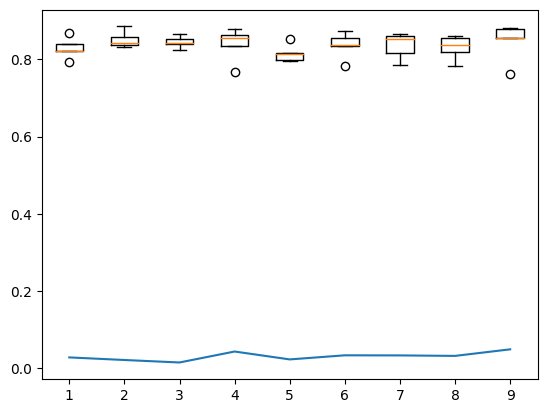

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
"1(100, 100)",0.828841,0.028237
"1(200, 200)",0.850413,0.021538
"1(300, 300)",0.844835,0.015124
"2(100, 100)",0.839273,0.043487
"2(200, 200)",0.815304,0.023057
"2(300, 300)",0.836687,0.033678
"3(100, 100)",0.835907,0.033421
"3(200, 200)",0.831103,0.032169
"3(300, 300)",0.845785,0.049155


We save the results in order to plot them together.

In [ ]:
folds = [["COR" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)

Finally, we can plot an example of inference.

In [ ]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
               get_items = get_image_files,
               get_y = get_y_fn,
               splitter = FuncSplitter(lambda x: Path(x).parent.name == "train"),
               item_tfms = [Resize((480,640)), TargetMaskConvertTransform()],
               batch_tfms = Normalize.from_stats(*imagenet_stats)
              )

dls = db.dataloaders(path_images, bs = 4)
learner = unet_learner(dls, **learner_hparams).to_fp16()
learner = learner.load("CutOutRandom")

mask = learner.predict(dls.train_ds[6][0])
print(np.unique(mask[0]))
mask = PILImage.create(decodes(mask[0]))

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0 1 2 3 4]


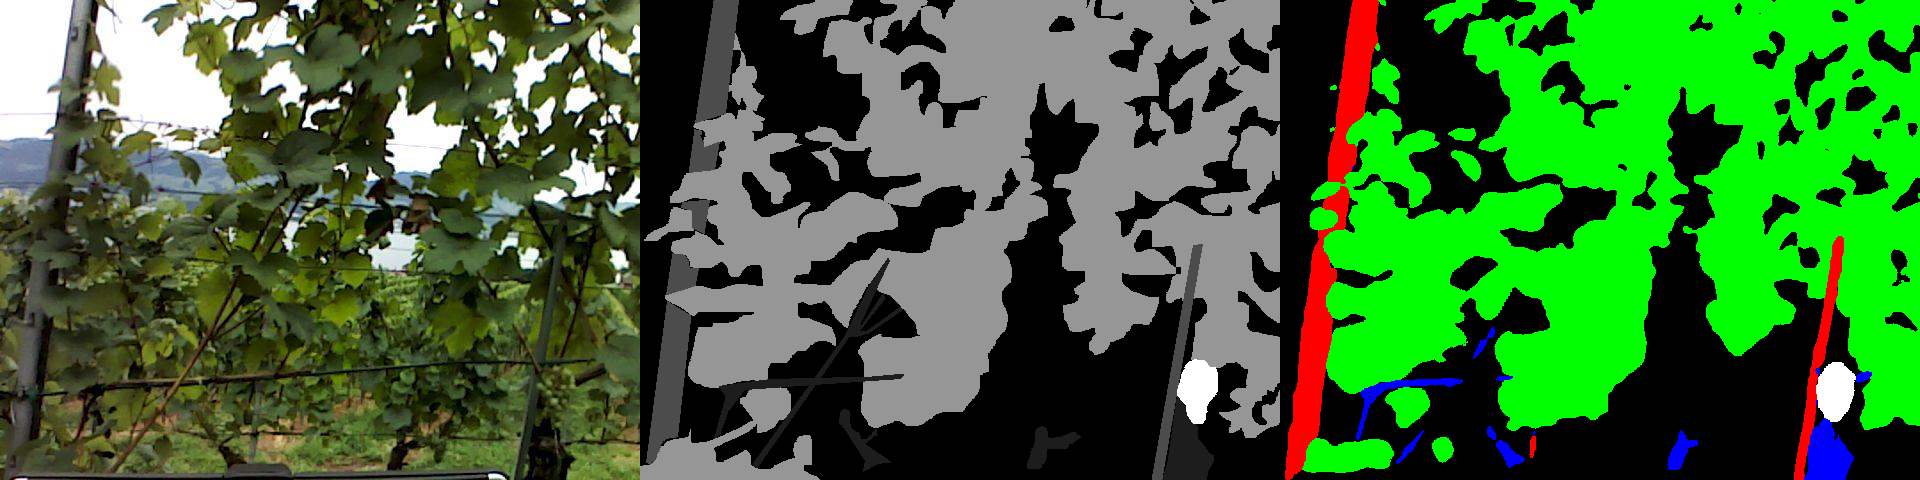

In [ ]:
image_grid([dls.train_ds[6][0], dls.train_ds[6][1], mask], rows = 1, cols = 3)